<h1><center>Dependencies Installation</center></h1>

In [2]:
%pip install pandas==2.2.2
%pip install matplotlib==3.9.2
%pip install seaborn==0.13.2
%pip install scikit-learn==1.5.2
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install skorch==1.0.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<h1><center>Import all needed libraries</center></h1>

In [3]:
import os
import random
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV

from skorch.callbacks import Callback
from skorch import NeuralNetClassifier

<h1><center>Setup agnostic device</center></h1

In [4]:
device_name = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

device = torch.device(device_name)
print(f"Using {device_name} device")

Using cuda device


<h1><center>Data Preparation</center></h1>

<h2>Read in dataset</h2>

In [5]:
ROOT_DIR: str = Path().resolve().parent
DATA_DIR: str = os.path.join(ROOT_DIR, 'data')

df: pd.DataFrame = pd.read_csv(f'{DATA_DIR}/almond.csv').drop(columns=["Unnamed: 0"])
df

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,NaN,192.709366,122.356506,18471.5,653.345233,NaN,0.931000,1.838965,NaN,NaN,0.725739,19840.5,SANORA
2799,NaN,186.254745,118.708961,17213.5,581.688379,NaN,0.952706,1.564234,NaN,NaN,0.714016,18068.0,SANORA
2800,NaN,186.196182,119.147224,17510.5,608.315795,NaN,0.948821,1.681705,NaN,NaN,0.718999,18455.0,SANORA
2801,NaN,188.660828,120.634438,17941.0,630.759446,NaN,0.944810,1.764701,NaN,NaN,0.738191,18989.0,SANORA


In [6]:
df.head()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA


In [7]:
df.tail()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
2798,NaN,192.709366,122.356506,18471.5,653.345233,NaN,0.931000,1.838965,NaN,NaN,0.725739,19840.5,SANORA
2799,NaN,186.254745,118.708961,17213.5,581.688379,NaN,0.952706,1.564234,NaN,NaN,0.714016,18068.0,SANORA
2800,NaN,186.196182,119.147224,17510.5,608.315795,NaN,0.948821,1.681705,NaN,NaN,0.718999,18455.0,SANORA
2801,NaN,188.660828,120.634438,17941.0,630.759446,NaN,0.944810,1.764701,NaN,NaN,0.738191,18989.0,SANORA
2802,269.356903,176.023636,NaN,36683.5,887.310743,0.643761,0.947380,1.707933,1.530231,0.75693,0.722429,38721.0,SANORA


In [8]:
df.columns

Index(['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)',
       'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness',
       'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)',
       'Type'],
      dtype='object')

<h2>Sanity-check on the dataset</h2>

<h3><li>Find and drop duplicates across rows</li></h3>

In [9]:
df.duplicated().sum()

3

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.duplicated().sum()

0

<h3><li>Check the shape of the dataset and see if there are any null values in columns</li></h3>

In [12]:
df.shape

(2800, 13)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2800 entries, 0 to 2802
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Length (major axis)       1944 non-null   float64
 1   Width (minor axis)        1859 non-null   float64
 2   Thickness (depth)         1797 non-null   float64
 3   Area                      2800 non-null   float64
 4   Perimeter                 2800 non-null   float64
 5   Roundness                 1944 non-null   float64
 6   Solidity                  2800 non-null   float64
 7   Compactness               2800 non-null   float64
 8   Aspect Ratio              1003 non-null   float64
 9   Eccentricity              1003 non-null   float64
 10  Extent                    2800 non-null   float64
 11  Convex hull(convex area)  2800 non-null   float64
 12  Type                      2800 non-null   object 
dtypes: float64(12), object(1)
memory usage: 306.2+ KB


In [14]:
df.isna().sum()

Length (major axis)          856
Width (minor axis)           941
Thickness (depth)           1003
Area                           0
Perimeter                      0
Roundness                    856
Solidity                       0
Compactness                    0
Aspect Ratio                1797
Eccentricity                1797
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64

In [15]:
(df.isnull().sum() / df.shape[0]) * 100

Length (major axis)         30.571429
Width (minor axis)          33.607143
Thickness (depth)           35.821429
Area                         0.000000
Perimeter                    0.000000
Roundness                   30.571429
Solidity                     0.000000
Compactness                  0.000000
Aspect Ratio                64.178571
Eccentricity                64.178571
Extent                       0.000000
Convex hull(convex area)     0.000000
Type                         0.000000
dtype: float64

<h3><li>Visualize the distribution of the data</li></h3>

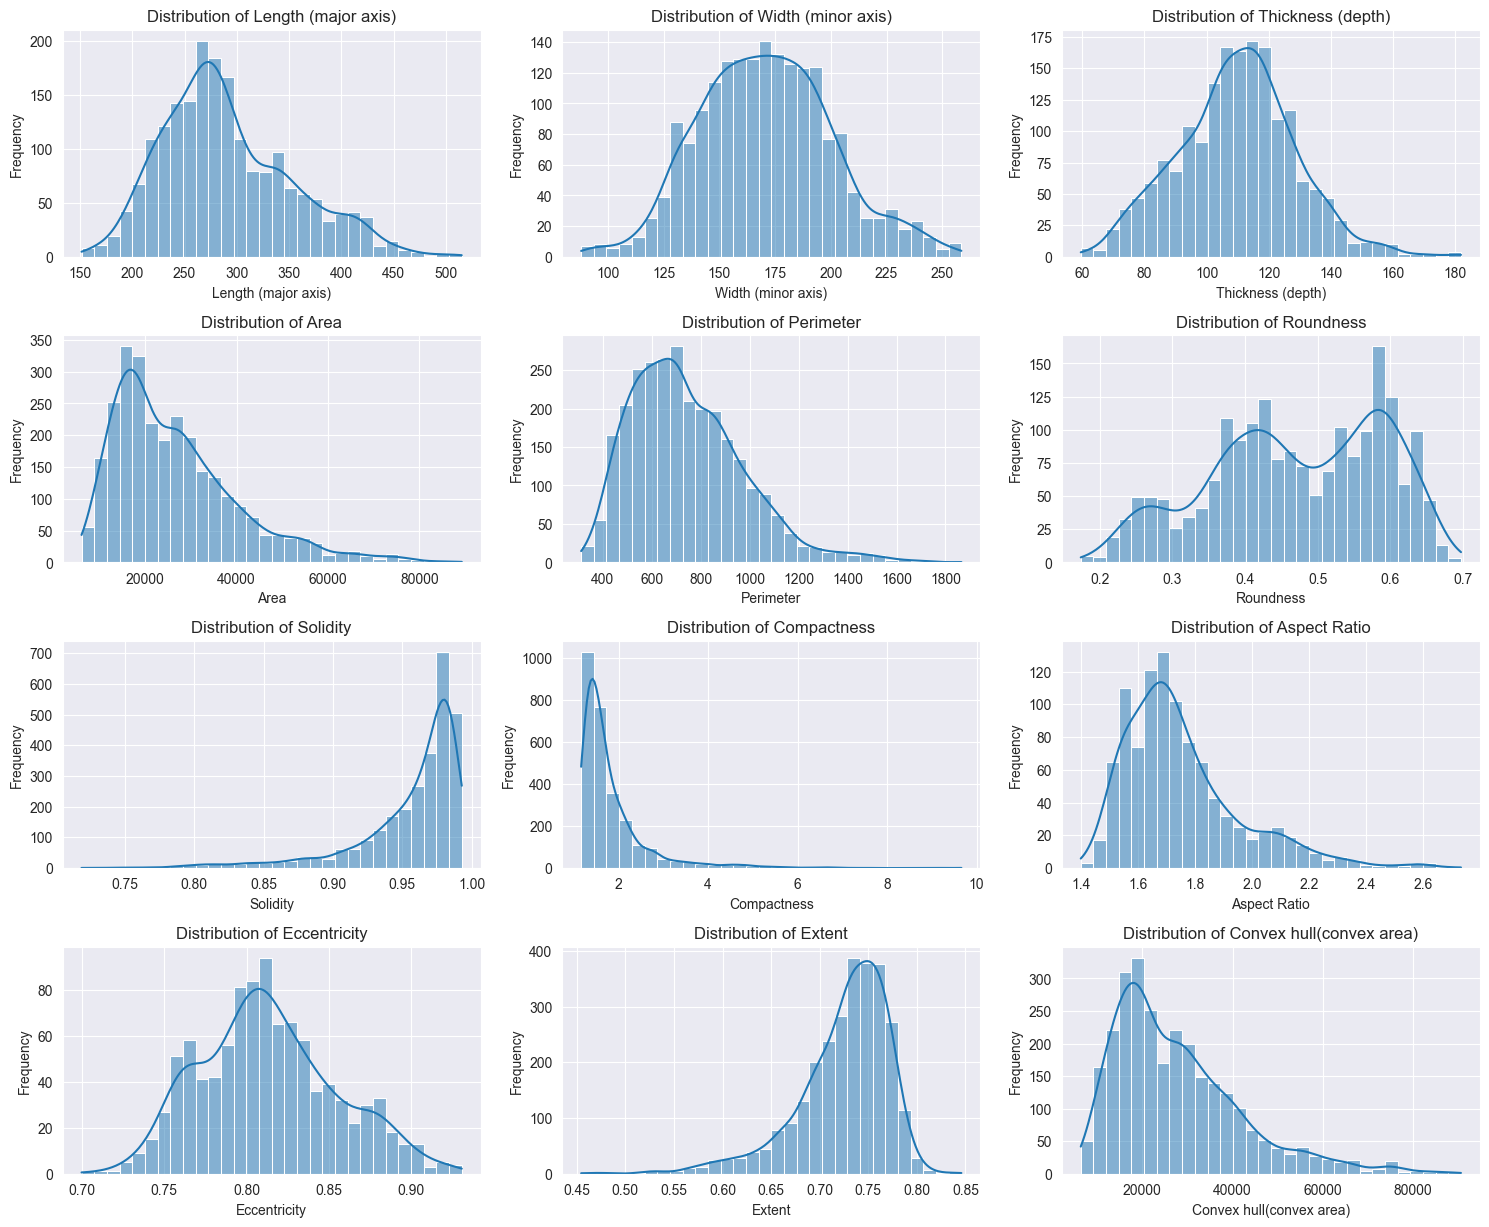

In [16]:
numeric_columns = df.columns

# Plot distributions for each numeric column
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
for i, column in enumerate(numeric_columns, 1):
    if column == 'Type':
        continue
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)  # Adjust the layout: 3 columns in each row
    sns.histplot(df[column], kde=True, bins=30)  # Histogram with Kernel Density Estimate (KDE)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<h3><li>Log transform the columns with outliers</li></h3>

In [1]:
for column_name in numeric_columns:
    if column_name != 'Type' and not (-0.5 < df[column_name].skew() < 0.5):
        print(column_name)
        df[column_name] = np.log(df[column_name])

NameError: name 'numeric_columns' is not defined

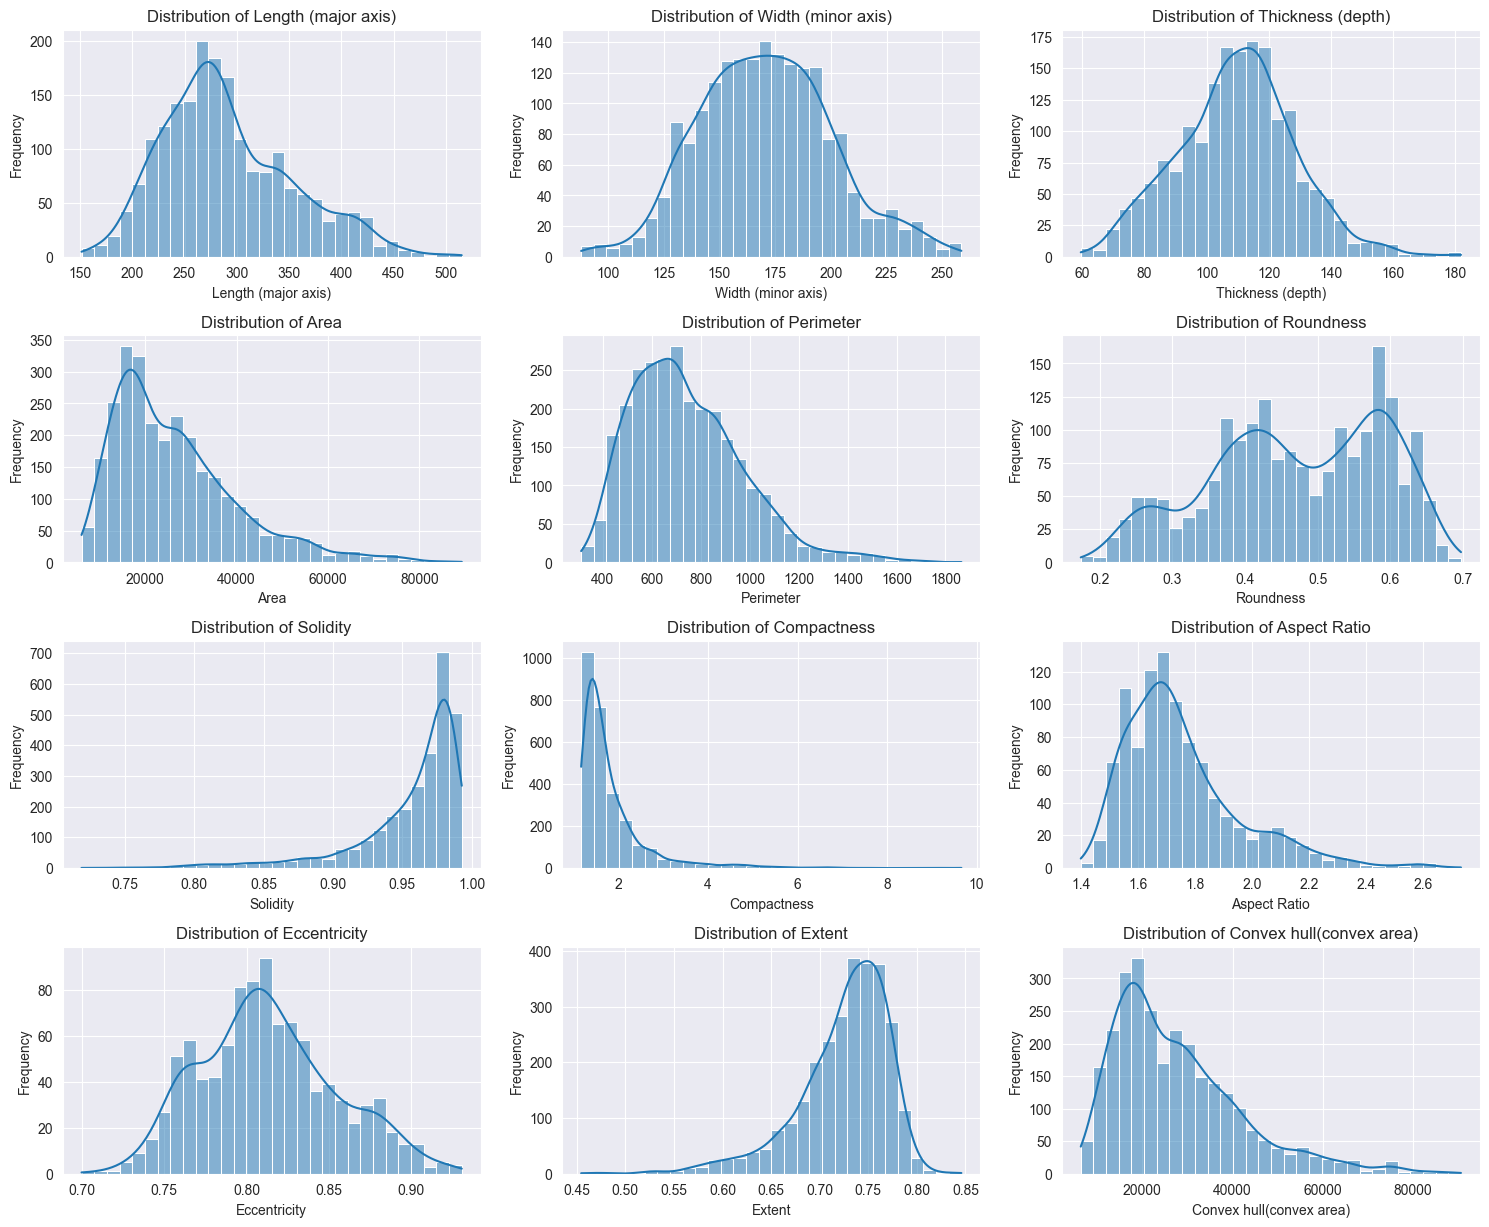

In [18]:
numeric_columns = df.columns

# Plot distributions for each numeric column
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
for i, column in enumerate(numeric_columns, 1):
    if column == 'Type':
        continue
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)  # Adjust the layout: 3 columns in each row
    sns.histplot(df[column], kde=True, bins=30)  # Histogram with Kernel Density Estimate (KDE)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<h3><li>Fill in the missing null values</li></h3>

In [19]:
columns_with_missing_values: List[str] = df.columns[df.isnull().any()].tolist()
knn_imputer: KNNImputer = KNNImputer(n_neighbors=5)
df[columns_with_missing_values] = knn_imputer.fit_transform(df[columns_with_missing_values])
df.isnull().sum()

Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

<h3><li>Find garbage values in the target variable 'Type'</li></h3>

In [20]:
column_name: str = 'Type'
print('****' * 5 + ' START ' + "****" * 5)
print(df[column_name].value_counts())
print('****' * 5 + ' END ' + "****" * 6)

******************** START ********************
Type
SANORA     943
MAMRA      931
REGULAR    926
Name: count, dtype: int64
******************** END ************************


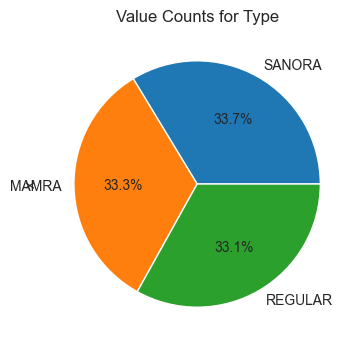

In [21]:
plt.figure(figsize=(8, 4))
df[column_name].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title(f'Value Counts for {column_name}')
plt.ylabel('x')
plt.show()

<h3><li>Encode the Target Variable</li></h3>

In [22]:
label_encoder: LabelEncoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])
df.head(10)

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,291.852063,227.940628,127.759132,22619.0,643.813269,0.435261,0.973384,1.458265,1.726178,0.813676,0.681193,23237.5,0
1,326.147974,234.188126,128.199509,23038.0,680.984841,0.386345,0.957304,1.601844,1.816562,0.834103,0.656353,24065.5,0
2,368.496790,229.418610,125.796547,22386.5,646.943212,0.373263,0.967270,1.487772,1.862117,0.843012,0.683620,23144.0,0
3,371.668274,232.763153,125.918808,22578.5,661.227483,0.323533,0.965512,1.540979,1.856913,0.842008,0.685360,23385.0,0
4,323.279550,230.150742,107.253448,19068.0,624.842706,0.341276,0.951450,1.629395,1.862117,0.843012,0.714800,20041.0,0
5,280.883673,231.914429,107.759789,19335.0,615.386863,0.384697,0.957344,1.558628,1.867326,0.844081,0.727920,20196.5,0
6,326.742126,226.371048,106.479408,18583.5,613.972649,0.376608,0.956286,1.614212,1.733808,0.812972,0.727908,19433.0,0
7,272.421838,226.186142,102.623077,18069.5,584.859952,0.374940,0.968978,1.506426,1.733808,0.812972,0.740675,18648.0,0
8,413.477173,208.762778,138.190536,41492.0,1078.984843,0.309009,0.950986,2.232834,2.040567,0.867574,0.767645,43630.5,0
9,418.210327,192.829520,129.659897,40630.5,1039.428493,0.295783,0.955888,2.116056,1.971019,0.856087,0.758598,42505.5,0


<h2>Exploratory Data Analysis (EDA)</h2>

<h3><li>Perform statistical analysis on the dataset</li></h3>

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Length (major axis),2800.0,292.366757,56.430595,151.335266,255.048988,285.335892,325.028860,515.352478
Width (minor axis),2800.0,170.469207,26.894826,88.050529,151.560583,169.743494,187.853066,258.569794
Thickness (depth),2800.0,109.935356,16.649750,59.494278,100.042352,110.526752,119.685385,181.845200
Area,2800.0,26503.354107,13763.416459,6037.000000,16214.000000,23421.000000,33448.000000,89282.000000
Perimeter,2800.0,743.573293,230.367902,311.563489,571.552339,707.144223,878.825462,1864.947387
Roundness,2800.0,0.464767,0.104252,0.173748,0.394901,0.460754,0.546314,0.697293
Solidity,2800.0,0.955919,0.039358,0.718772,0.944733,0.970482,0.981490,0.992889
Compactness,2800.0,1.823211,0.789515,1.164469,1.357361,1.576375,1.963977,9.660057
Aspect Ratio,2800.0,1.753156,0.157166,1.400082,1.654028,1.723937,1.817199,2.731251
Eccentricity,2800.0,0.813203,0.031411,0.699897,0.794185,0.811385,0.831028,0.930563


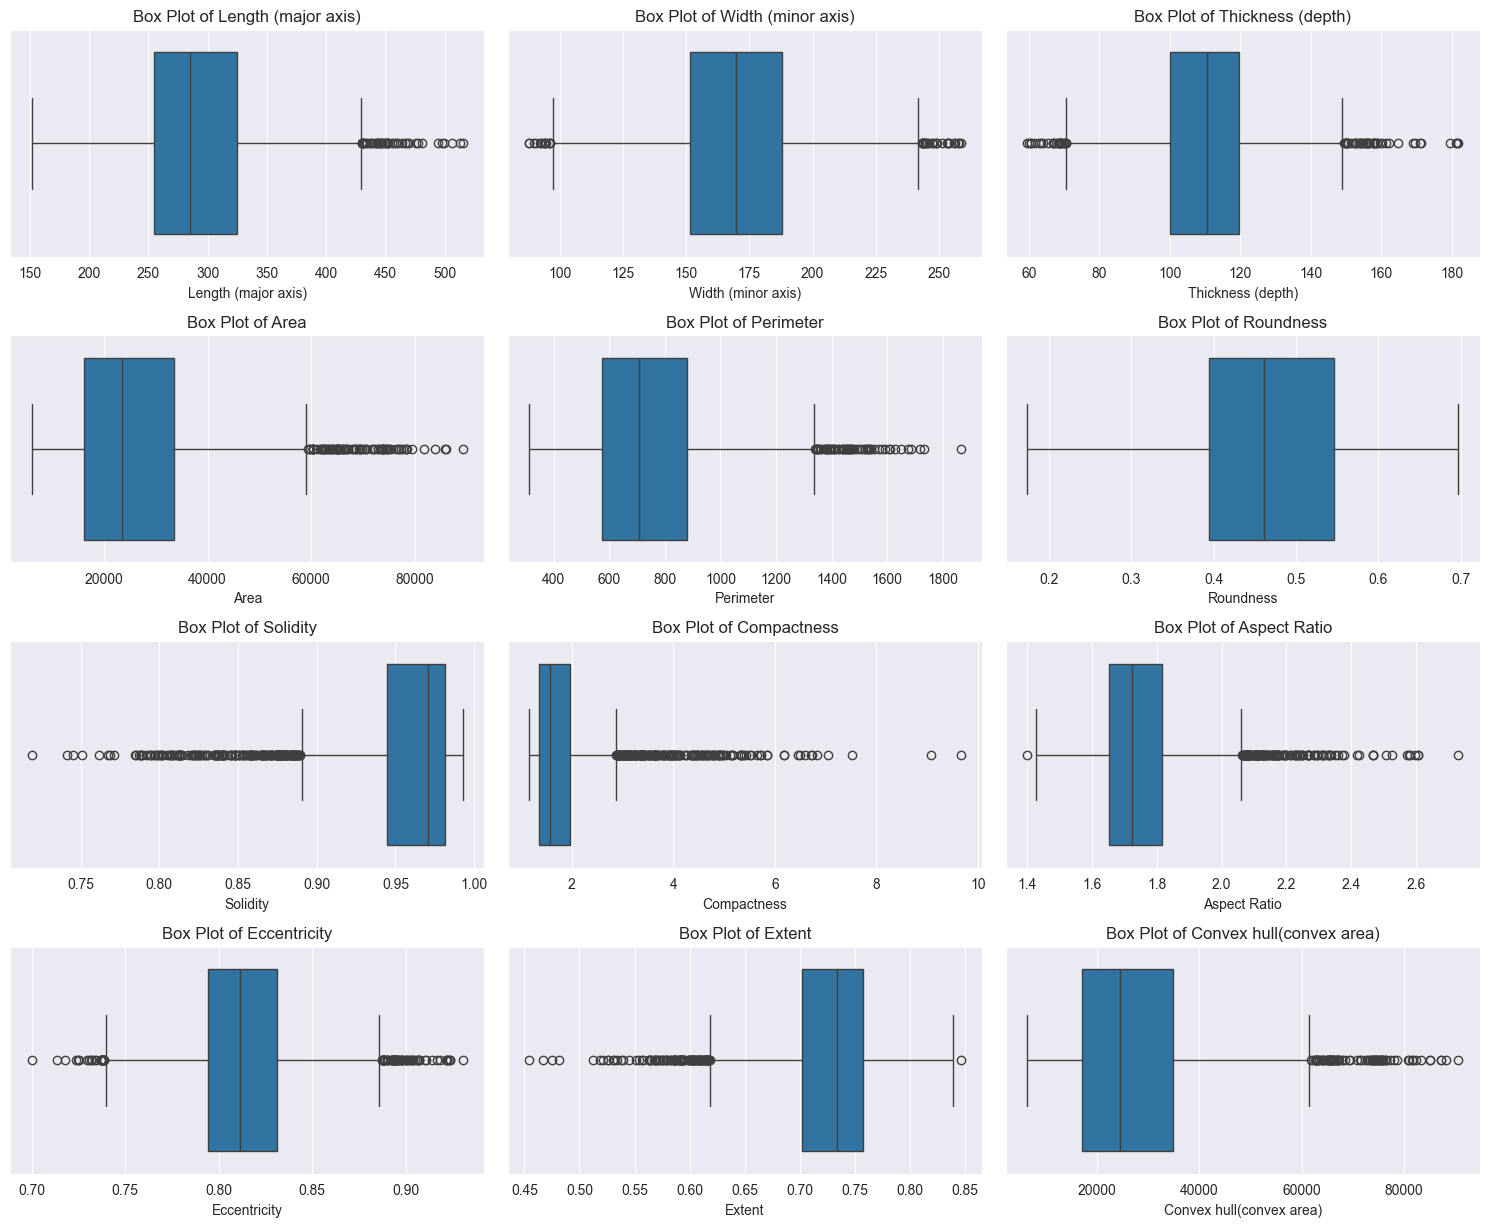

In [24]:
# Plot box plots for each numeric column
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
for i, column in enumerate(numeric_columns, 1):
    if column == 'Type':
        continue
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)  # Adjust the layout: 3 columns in each row
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

<h3><li>Standardize the features data</li></h3>

In [25]:
scaler = StandardScaler()

columns_to_scale: List[str] = df.columns.tolist()
columns_to_scale.remove('Type')

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.head()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,-0.009122,2.137277,1.070704,-0.282274,-0.433124,-0.283077,0.443820,-0.462322,-0.171684,0.015047,-0.917091,-0.313030,0
1,0.598740,2.369612,1.097159,-0.251825,-0.271738,-0.752375,0.035200,-0.280433,0.403504,0.665485,-1.441111,-0.254773,0
2,1.349332,2.192241,0.952809,-0.299169,-0.419535,-0.877875,0.288464,-0.424943,0.693409,0.949162,-0.865885,-0.319609,0
3,1.405544,2.316619,0.960153,-0.285217,-0.357517,-1.354977,0.243787,-0.357538,0.660293,0.917177,-0.829174,-0.302652,0
4,0.547900,2.219468,-0.161107,-0.540322,-0.515488,-1.184752,-0.113577,-0.245531,0.693409,0.949162,-0.208101,-0.537931,0


<h2>Turn data into tensors and split the data into train and test datasets</h2>

In [26]:
almond_features = df.drop('Type', axis=1)
almond_types = df['Type']

num_of_features: int = len(almond_features.columns)
num_of_classes: int = almond_types.nunique()

almond_features_torch = torch.from_numpy(almond_features.values).type(torch.float)
almond_types_torch = torch.from_numpy(almond_types.values).type(torch.long)

X_train, X_test, y_train, y_test = train_test_split(almond_features_torch, almond_types_torch, test_size=0.2,
                                                    shuffle=True)

<h1><center>Implementation</center></h1>

<h2>Setup NeuralNetwork</h2>


In [27]:
class AlmondClassificationNN(nn.Module):
    def __init__(
            self,
            in_features: int = 12,
            hidden_layers=None,
            out_features: int = 3
    ):
        super(AlmondClassificationNN, self).__init__()
        if hidden_layers is None:
            hidden_layers = [(10, 10)]

        self.input = nn.Linear(in_features, hidden_layers[0][0])
        self.input_activation = nn.ReLU()
        
        nn.init.kaiming_normal_(self.input.weight)
        nn.init.zeros_(self.input.bias)
        
        # self.hidden_layers = nn.ModuleList()
        # self.num_of_hidden_layers = len(hidden_layers)
        # for index in range(0, self.num_of_hidden_layers):
        #     in_neurons, out_neurons = hidden_layers[index]
        #     self.hidden_layers.append(nn.Linear(in_neurons, out_neurons))
        #     self.hidden_layers.append(nn.ReLU())

        self.output = nn.Linear(hidden_layers[-1][1], out_features)
        self.output_activation = F.softmax

        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, features):
        features = self.input_activation(self.input(features))

        # for hidden_layer in self.hidden_layers:
        #     features = hidden_layer(features)

        return self.output_activation(features, dim=-1)

<h2>Setup Callbacks, NeuralNetClassifier, and GridSearchCV</h2>


<h3><li>Setup Callbacks</li></h3>

In [28]:
class FixSeed(Callback):
    def __init__(self, seed=4464):
        self.seed = seed

    def initialize(self):
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)

        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        return super().initialize()

<h3><li>Setup NeuralNetClassifier</li></h3>

In [29]:
neuralnet_classifier = NeuralNetClassifier(
    module=AlmondClassificationNN,
    module__in_features=num_of_features,
    module__out_features=num_of_classes,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    max_epochs=500,
    batch_size=32,
    callbacks=[FixSeed()],
    verbose=True,
    device=device
)

<h3><li>Setup GridSearchCV</li></h3>

In [30]:
param_grid: dict = {
    'optimizer__lr': [0.01, 0.03],
    'optimizer__momentum': [ 0.4],
    'module__hidden_layers': [[(512, 256), (256, 128),(128, 64)]],
    'batch_size': [15]
}

grid = GridSearchCV(
    estimator=neuralnet_classifier,
    param_grid=param_grid,
    n_jobs=1,
    cv=5,
    verbose=0
)
grid_result = grid.fit(almond_features_torch, almond_types_torch)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ished\Desktop\TUKS\COS 711 - Artificial Intelligence (II)\Assignments\02\hybrid-learning-in-neural-networks-for-almond-classification\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ished\Desktop\TUKS\COS 711 - Artificial Intelligence (II)\Assignments\02\hybrid-learning-in-neural-networks-for-almond-classification\venv\Lib\site-packages\skorch\classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ished\Desktop\TUKS\COS 711 - Artificial Intelligence (II)\Assignments\02\hybrid-learning-in-neural-networks-for-almond-classification\venv\Lib\site-packages\skorch\net.py", line 1317, in fit
    self.initialize()
  File "C:\Users\ished\Desktop\TUKS\COS 711 - Artificial Intelligence (II)\Assignments\02\hybrid-learning-in-neural-networks-for-almond-classification\venv\Lib\site-packages\skorch\net.py", line 905, in initialize
    self._initialize_optimizer()
  File "C:\Users\ished\Desktop\TUKS\COS 711 - Artificial Intelligence (II)\Assignments\02\hybrid-learning-in-neural-networks-for-almond-classification\venv\Lib\site-packages\skorch\net.py", line 876, in _initialize_optimizer
    self.initialize_optimizer()
  File "C:\Users\ished\Desktop\TUKS\COS 711 - Artificial Intelligence (II)\Assignments\02\hybrid-learning-in-neural-networks-for-almond-classification\venv\Lib\site-packages\skorch\net.py", line 642, in initialize_optimizer
    self.optimizer_ = self.optimizer(*args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Adam.__init__() got an unexpected keyword argument 'momentum'


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))